Machine Learning models for obesity risk prediction

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import math
import sklearn as sk

In [2]:
# Load data
data = pd.read_csv("Data_collection_and_cleaning/processed_data/csv_files/Processed_data.csv",
                   header= 0)

Descriptive analysis

In [11]:
data.head(2)

,subjid,sex,age_days,age_years,date_of_measurement,height_cm,weight_kg,bmi,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,763,2.089023,2015-11-13,87.0,13.2,17.439556,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1118,3.060980,2016-11-02,96.0,15.9,17.252604,1.30,Overweight


In [12]:
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

Number of rows: 95977, Number of columns: 10


In [13]:
data.describe()

,age_days,age_years,height_cm,weight_kg,bmi,zbmi
count,95977.000000,95977.000000,95977.000000,95977.00000,95977.000000,95977.000000
mean,1951.170989,5.342125,111.183477,21.88861,16.836618,0.540136
std,951.657055,2.605549,17.969964,10.20711,2.734057,1.281769
min,731.000000,2.001410,56.000000,4.75000,9.696841,-5.230000
25%,1125.000000,3.080145,96.500000,14.80000,15.095763,-0.330000
50%,1696.000000,4.643490,108.500000,18.70000,16.174885,0.430000
75%,2540.000000,6.954284,124.000000,26.00000,17.728532,1.310000
max,5200.000000,14.237116,180.000000,106.50000,38.295657,9.300000


In [66]:
# Check NA count
data.isna().sum()

subjid                 0
sex                    0
age_days               0
age_years              0
date_of_measurement    0
height_cm              0
weight_kg              0
bmi                    0
zbmi                   0
zbmi_type              0
dtype: int64

In [14]:
data.dtypes

subjid                  object
sex                     object
age_days                 int64
age_years              float64
date_of_measurement     object
height_cm              float64
weight_kg              float64
bmi                    float64
zbmi                   float64
zbmi_type               object
dtype: object

In [8]:
# Number of patients
len(data.subjid.unique())

27009

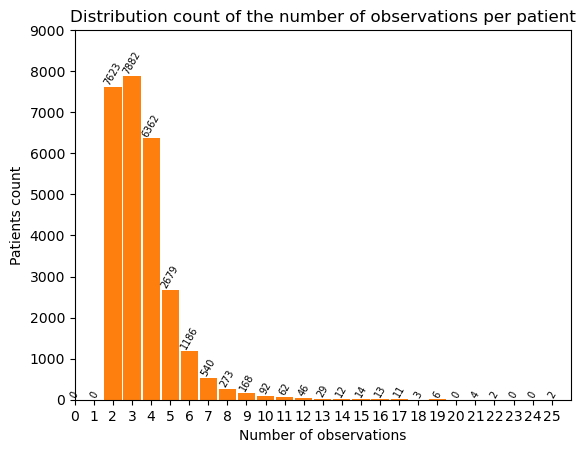

In [15]:
# Plot number of patients by number of obs
n_patients = data.value_counts("subjid")
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 9000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Distribution count of the number of observations per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Number of observations")

plt.show()

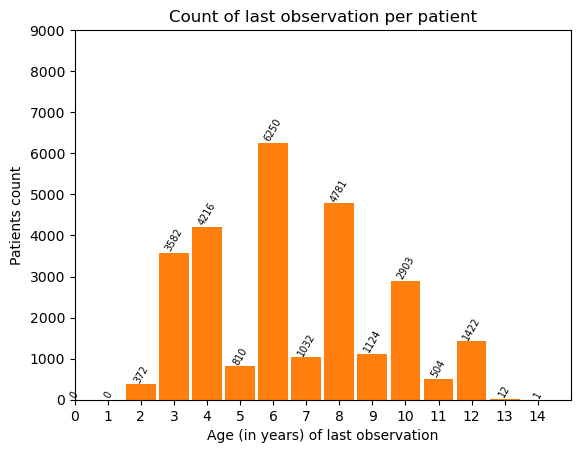

In [37]:
# Plot number of patients by age_years of obs
n_patients = data.groupby("subjid")["age_years"].max().apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 9000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of last observation per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Age (in years) of last observation")

plt.show()

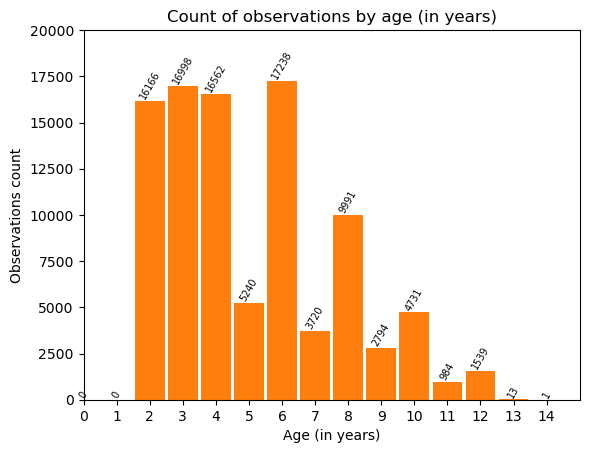

In [3]:
# Plot observations by age_years
n_patients = data.age_years.apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 20000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of observations by age (in years)")
ax.set_ylabel("Observations count")
ax.set_xlabel("Age (in years)")

plt.show()

Since we have very few observation at 13 and 14 years old, the objective will be changed to a prediction of the obesity risk at 12 years old, the last year of prepusbescent age.

In [4]:
data12 = data[data['age_years'].apply(math.trunc) <= 12].copy()

In [5]:
# Redo analysis
data12.describe()

,age_days,age_years,height_cm,weight_kg,bmi,zbmi
count,95963.000000,95963.000000,95963.000000,95963.000000,95963.000000,95963.000000
mean,1950.748247,5.340967,111.176591,21.883617,16.835905,0.540143
std,951.081758,2.603973,17.961604,10.195920,2.732670,1.281671
min,731.000000,2.001410,56.000000,4.750000,9.696841,-5.230000
25%,1125.000000,3.080145,96.500000,14.800000,15.095599,-0.330000
50%,1695.000000,4.640752,108.500000,18.700000,16.174885,0.430000
75%,2539.000000,6.951546,123.800000,26.000000,17.728532,1.310000
max,4747.000000,12.996845,180.000000,106.500000,38.295657,9.300000


In [6]:
print(f"Number of rows: {data12.shape[0]}, Number of columns: {data12.shape[1]}")

Number of rows: 95963, Number of columns: 10


In [7]:
# Number of patients
len(data12.subjid.unique())

27009

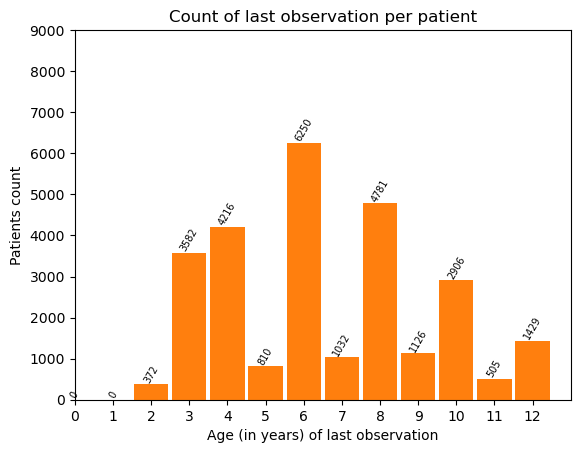

In [60]:
# Plot number of patients by age_years of obs
n_patients = data12.groupby("subjid")["age_years"].max().apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 9000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of last observation per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Age (in years) of last observation")

plt.show()

After filtering the data we find that we do not loose any patients.
We will consider the following models for comparison: LSTM, GRU, Transformers, Random Forest, XGBoost, HMM, and Gaussoan Processes.

To train the models reshaping of our data is needed so we have one row per patient.

In [8]:
# Filter data12
data12["age_years"] = data12["age_years"].apply(math.trunc)
data12 = data12.loc[:, ["subjid", "sex", "age_years", "zbmi", "zbmi_type"]]
data12.head(10)

,subjid,sex,age_years,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,3,1.30,Overweight
2,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,4,0.73,Normal_weight
3,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,4,0.79,Normal_weight
4,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,6,0.66,Normal_weight
5,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,8,0.23,Normal_weight
6,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,6,1.77,Overweight
7,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,8,2.92,Obese
8,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,9,3.13,Obese
9,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,10,3.00,Obese


In [34]:
# Reshape data
zbmi_pivoted = data12.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi")
zbmi_types_pivoted = data12.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi_type", aggfunc="first")

# Combine multilevel columns
zbmi_pivoted.columns = [f"zbmi_{col}" for col in zbmi_pivoted.columns]
zbmi_types_pivoted.columns = [f"zbmi_type_{col}" for col in zbmi_types_pivoted.columns]

# Combine data
pivot_data = pd.merge(zbmi_pivoted, zbmi_types_pivoted, on=["subjid", "sex"], how="outer")
pivot_data.reset_index(inplace=True)

pivot_data.head(5)

,subjid,sex,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,...,zbmi_type_3,zbmi_type_4,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1.24,1.30,0.73,NaN,NaN,NaN,NaN,NaN,...,Overweight,Normal_weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,NaN,NaN,0.79,NaN,0.66,NaN,0.23,NaN,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,NaN,NaN,NaN,NaN,1.77,NaN,2.92,3.13,...,NaN,NaN,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,NaN
3,++TMQDydqMEDVhkvMZorEAz5uNqfvTjPSUCE,Male,NaN,1.45,1.54,NaN,2.03,NaN,NaN,NaN,...,Overweight,Overweight,NaN,Obese,NaN,NaN,NaN,NaN,NaN,NaN
4,++Tuo70jTBg1CFM1eHHrLwz5uNqRtD/LTUiA,Female,NaN,NaN,NaN,NaN,0.97,NaN,1.19,NaN,...,NaN,NaN,NaN,Normal_weight,NaN,Overweight,NaN,Overweight,NaN,NaN


In [35]:
# Add ages again
names = ["age_" + str(x) for x in range(2, 13, 1)]
ages = [x for x in range(2, 13, 1)]
age_dict = dict(zip(names, ages))

for agename, agevalue in age_dict.items():
    pivot_data[agename] = agevalue

# Reorder columns
age_cols = [col for col in pivot_data.columns if 'age' in col]

pivot_data = pivot_data[["subjid", "sex"] + 
                        age_cols + 
                        [col for col in pivot_data.columns if col not in age_cols] or ["subjid", "sex"]]

pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_3,zbmi_type_4,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,Overweight,Normal_weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,NaN,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,NaN


In [40]:
# Check if the patient number is not affected
len(pivot_data)

27009

Data will be split between 67% train and 33% test, stratifying by label zbmi_type_12 to ensure we have some final data points in both train and test subsets.
Some models need further preparation after train-test split, so data will be prepared individually in order to maximize performance of each model. 

In [ ]:
# Train-test split 67%-33%
y = pivot_data.pop("zbmi_type_12")
y.fillna("Unknown", inplace=True)


xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(pivot_data, y,
                                                                   test_size=0.33,
                                                                   random_state=42,
                                                                   stratify=y)

In [46]:
# Dataframe shapes
print(f"Xtrain: number of rows = {xtrain.shape[0]}, number of columns = {xtrain.shape[1]}")
print(f"Xtest: number of rows = {xtest.shape[0]}, number of columns = {xtest.shape[1]}")
print(f"Ytrain: number of rows = {ytrain.shape[0]}")
print(f"Ytest: number of rows = {ytest.shape[0]}")

Xtrain: number of rows = 18096, number of columns = 36
Xtest: number of rows = 8913, number of columns = 36
Ytrain: number of rows = 18096
Ytest: number of rows = 8913
